# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [2]:
%%capture --no-stderr
! python -m pip install --quiet -U langchain_core langgraph langchain_openai langchain_google_genai


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langgraph-gemini`. 

In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-gemini"

## Messages as state

First, let's define some messages.

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Dhiraj"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Dhiraj

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm.invoke(messages)

AIMessage(content='That\'s great! Whales are fascinating creatures. But there\'s a whole world of other amazing ocean mammals out there! Here are some groups you might want to explore:\n\n**1.  Dolphins and Porpoises:**\n\n* **Dolphins:** These are some of the most intelligent and social creatures in the ocean. They come in a variety of shapes and sizes, from the small Amazon River dolphin to the massive orca (killer whale). \n* **Porpoises:** These are often mistaken for dolphins, but they have a more stout body shape and smaller, triangular dorsal fins. \n\n**2.  Seals and Sea Lions:**\n\n* **Seals:**  These are generally smaller than sea lions and have small, flipper-like forelimbs that are difficult to use for walking on land. They are excellent swimmers.\n* **Sea Lions:** These are larger than seals and have larger, more prominent flippers that they use to "walk" on land. \n\n**3.  Walruses:** \n\n* **Walruses:** These are massive, tusked animals that inhabit the Arctic. They are 

We can run our chat model in a simple graph with `MessagesState`.

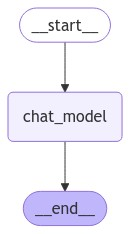

In [9]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Dhiraj

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating!  But the ocean is teeming with other amazing mammals. Here's a breakdown of some of the most interesting groups to learn about:

**1.  The "Big Three":**

* **Whales:**  These are the giants of the ocean, with over 80 species ranging from the tiny dwarf sperm whale to the massive blue whale. You already know about them, but there's always more to learn!
* **Dolphins and Porpoises:**  These playful, intelligent creatures are incredibly diverse, with over 40 species.  They're known for their complex social structures, communication abilities, and acrobatic skills.
* **Seals an

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

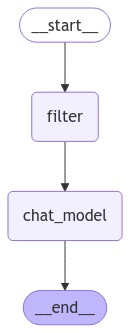

In [11]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

C:\Users\dpokh\AppData\Local\Temp\ipykernel_28464\2487060097.py:6: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's awesome! Whales are fascinating creatures.  There's a whole world of ocean mammals to explore beyond whales though. Here are some other groups you might find interesting:

**1.  Dolphins and Porpoises:**

* **Dolphins:** These intelligent and social animals are known for their playful nature and complex communication. There are over 40 species of dolphins, each with unique characteristics.
* **Porpoises:**  Similar to dolphins but with smaller, more stocky bodies and blunt snouts. They are often solitary or live in small groups. 

**2.  Seals and Sea Lions:**

* **Seals:**  These animals have smooth, strea

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

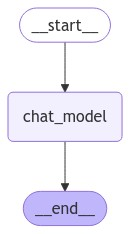

In [13]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [14]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [15]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's awesome! Whales are fascinating creatures.  There's a whole world of ocean mammals to explore beyond whales though. Here are some other groups you might find interesting:

**1.  Dolphins and Porpoises:**

* **Dolphins:** These intelligent and social animals are known for their playful nature and complex communication. There are over 40 species of dolphins, each with unique characteristics.
* **Porpoises:**  Similar 

In [16]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's awesome! Whales are fascinating creatures.  There's a whole world of ocean mammals to explore beyond whales though. Here are some other groups you might find interesting:

**1.  Dolphins and Porpoises:**

* **Dolphins:** These intelligent and social animals are known for their playful nature and complex communication. There are over 40 species of dolphins, each with unique characteristics.
* **Porpoises:**  Similar 

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

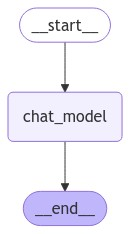

In [22]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [24]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [25]:
# Invoke, using message trimming
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

In [26]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', name='Bot', id='1'),
  HumanMessage(content='Hi.', name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4'),
  AIMessage(content='That\'s awesome! Whales are fascinating creatures.  There\'s a whole world of ocean mammals to explore beyond whales though. Here are some other groups you might find interesting:\n\n**1.  Dolphins and Porpoises:**\n\n* **Dolphins:** These intelligent and social animals are known for their playful nature and complex communication. There are over 40 species of dolphins, each with unique characteristics.\n* **Porpoises:**  Similar to dolphins but with smaller, more stocky bodies and blunt snouts. They are often solitary or live in small groups. \n\n**2.  Seals and Sea Lions:**\n\n* **Seals:**  These animals have smooth, streamlined bodies and flippers for